In [1]:
%cd ..
%cd ..
%cd ..

    
from trademl.data_process import DataLoader



/home/blah-blah/Projects/TradingML/trademl/experiments
/home/blah-blah/Projects/TradingML/trademl
/home/blah-blah/Projects/TradingML


In [9]:
start_date = "2019-01-01"
end_date="2019-01-11" #"2025-12-01",

# Загружаем данные с новой структурой
dfs = DataLoader.load_crypto_data_single_timeframe(
    symbols=["BTCUSDT"],# "ETHUSDT"],#, "ADAUSDT", "AVAXUSDT", "DOGEUSDT", "LINKUSDT"],
    timeframe="5m",
    start_date=start_date,
    end_date=end_date,
    data_root="./trademl/data/crypto"
)

df = dfs["BTCUSDT"]

Filtering data from: 2019-01-01 00:00:00
Filtering data until: 2019-01-11 00:00:00
Loaded BTCUSDT @ 5m: 2881 records (filtered from 831110)


In [26]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from joblib import Parallel, delayed

def _sadf_for_t1(series: pd.Series, t1: int, min_window: int) -> float:
    """Вычисляет SADF статистику для фиксированного конечного окна t1."""
    adf_stats = []
    for t0 in range(0, t1 - min_window + 1):
        sub_series = series.iloc[t0:t1]
        adf_res = adfuller(sub_series, maxlag=0, regression="c", autolag=None)
        adf_stats.append(adf_res[0])
    return np.max(adf_stats)

def sadf_parallel(series: pd.Series, min_window: int = 30, n_jobs: int = -1) -> pd.Series:
    """Распараллеленная реализация Supremum ADF (SADF)."""
    results = Parallel(n_jobs=n_jobs)(
        delayed(_sadf_for_t1)(series, t1, min_window)
        for t1 in range(min_window, len(series) + 1)
    )
    return pd.Series(results, index=series.index[min_window - 1:])

# --- 1. Синтетические данные (пузыри и крахи) ---

series = np.log(df.Close)



# --- 3. Считаем SADF ---
sadf_series = sadf_parallel(series, min_window=30)


In [27]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CrosshairTool
import numpy as np

output_notebook()

# нормализация в [0,1]
def minmax_norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

price_norm = minmax_norm(series.values)
sadf_norm = minmax_norm(sadf_series.reindex(series.index).fillna(method="bfill").values)

source = ColumnDataSource(data=dict(
    x=series.index,
    price=price_norm,
    sadf=sadf_norm,
    price_raw=series.values,
    sadf_raw=sadf_series.reindex(series.index).fillna(method="bfill").values
))

p = figure(x_axis_type="datetime", width=950, height=400, title="Цена и SADF (нормированные)")

# линии
p.line("x", "price", source=source, color="navy", legend_label="Цена (норм.)")
p.line("x", "sadf", source=source, color="orange", legend_label="SADF (норм.)")

# Hover с реальными значениями
p.add_tools(HoverTool(
    tooltips=[
        ("Дата", "@x{%F %T}"),
        ("Цена", "@price_raw{0.00}"),
        ("SADF", "@sadf_raw{0.000}")
    ],
    formatters={"@x": "datetime"},
    mode="vline"
))

# Crosshair (по умолчанию рисует и вертикаль, и горизонталь)
crosshair = CrosshairTool(dimensions="height", line_color="red", line_alpha=0.8)
p.add_tools(crosshair)

p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)



Loading BokehJS ...

/tmp/ipykernel_89245/2074447214.py:12: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_89245/2074447214.py:19: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



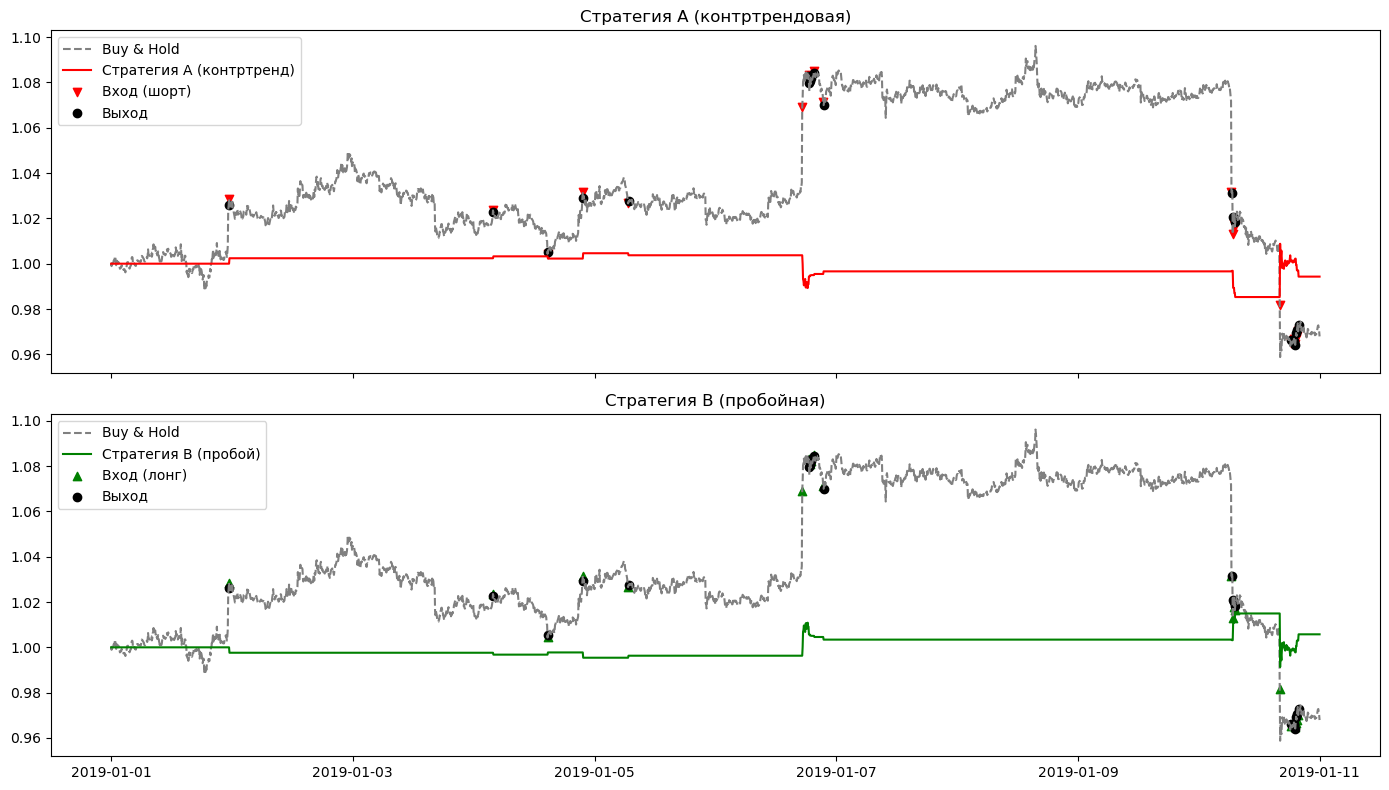

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Данные ---
log_price = series

# --- 2. Генерация сигналов ---
def generate_signals(sadf: pd.Series, upper: float = 1.0, lower: float = 1.5, mode="short"):
    """
    mode = "short" → контртрендовая стратегия (A)
    mode = "long"  → пробойная стратегия (B)
    """
    signal = pd.Series(0, index=sadf.index)  # 0 = нет позиции
    entries, exits = [], []
    in_position = False
    
    for t in sadf.index:
        if not in_position:
            if sadf.loc[t] > upper:
                signal.loc[t] = -1 if mode == "short" else 1
                entries.append(t)
                in_position = True
        else:
            if sadf.loc[t] < lower:
                signal.loc[t] = 0
                exits.append(t)
                in_position = False
            else:
                signal.loc[t] = -1 if mode == "short" else 1
    return signal, entries, exits

# --- 3. Сигналы ---
signals_A, entries_A, exits_A = generate_signals(sadf_series, mode="short")
signals_B, entries_B, exits_B = generate_signals(sadf_series, mode="long")

# --- 4. Доходности ---
returns = log_price.diff().fillna(0)
strategy_A_returns = (signals_A.shift(1) * returns).fillna(0)
strategy_B_returns = (signals_B.shift(1) * returns).fillna(0)
equity_A = strategy_A_returns.cumsum().apply(np.exp)
equity_B = strategy_B_returns.cumsum().apply(np.exp)

# --- 5. Визуализация ---
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# График цен + точки входа/выхода для стратегии A
ax[0].plot(df.index, np.exp(log_price - log_price.iloc[0]), label="Buy & Hold", linestyle="--", color="gray")
ax[0].plot(df.index, equity_A, label="Стратегия A (контртренд)", color="red")
ax[0].scatter(entries_A, np.exp(log_price.loc[entries_A] - log_price.iloc[0]), marker="v", color="red", label="Вход (шорт)")
ax[0].scatter(exits_A, np.exp(log_price.loc[exits_A] - log_price.iloc[0]), marker="o", color="black", label="Выход")
ax[0].legend()
ax[0].set_title("Стратегия A (контртрендовая)")

# График цен + точки входа/выхода для стратегии B
ax[1].plot(df.index, np.exp(log_price - log_price.iloc[0]), label="Buy & Hold", linestyle="--", color="gray")
ax[1].plot(df.index, equity_B, label="Стратегия B (пробой)", color="green")
ax[1].scatter(entries_B, np.exp(log_price.loc[entries_B] - log_price.iloc[0]), marker="^", color="green", label="Вход (лонг)")
ax[1].scatter(exits_B, np.exp(log_price.loc[exits_B] - log_price.iloc[0]), marker="o", color="black", label="Выход")
ax[1].legend()
ax[1].set_title("Стратегия B (пробойная)")

plt.tight_layout()
plt.show()
